In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np

In [2]:
os.chdir("/Users/aaran/MHA_Upload_my_changes/Duke_Dataset")
df = pd.read_csv("dukecathr.csv")

In [3]:
def create_subj_dict(df):
    subjects = dict()
    for index, row in df.iterrows():
        if row["RSUBJID"] not in subjects.keys():
            subjects[row["RSUBJID"]] = list()

        subjects[row["RSUBJID"]].append(row.drop(columns="RSUBJID"))
    return subjects

def find_threshold_num_visits(subj_dict, threshold, percentage=True):
    num_visit_count = dict()
    for k in subj_dict.keys():
        instances = len(subj_dict[k])
        if instances not in num_visit_count.keys():
            num_visit_count[instances] = 0
        num_visit_count[instances] += 1
    
    num_subj = len(subj_dict)
    if percentage:
        thresh = num_subj * (1 - threshold)
    else:
        thresh = num_subj - threshold
    running_sum = 0
    sorted_keys = list(num_visit_count.keys())
    sorted_keys.sort()
    for k in sorted_keys:
        running_sum += num_visit_count[k]
        # print(running_sum)
        # print(k)
        if running_sum >= thresh:
            return k

# requires that entries for each subject in subj_dict are entered in chronological order
# min_instances only has effect if custom_filterer is None
def avg_interval(subj_dict, min_instances=2, per_instance=True, custom_filterer=None):
    def filterer(pair):
        key, value = pair
        if len(value) >= min_instances:
            return True
        return False
    if custom_filterer is None:
        multi_subj = dict(filter(filterer, subj_dict.items()))
    else:
        multi_subj = dict(filter(custom_filterer, subj_dict.items()))
    sum = 0
    for k in multi_subj.keys():
        interval = multi_subj[k][-1]["RDAYSFROMINDEX"] - multi_subj[k][0]["RDAYSFROMINDEX"]
        if per_instance:
            interval = interval / (len(multi_subj[k]) - 1)
        sum += interval
    print(len(multi_subj))
    if len(multi_subj) == 0:
        return None
    return (sum / len(multi_subj))

def graph_col(subj_dict, subj_id, col_name):
    def one_col(row):
        return row[col_name]
    def index_col(row):
        return row["RDAYSFROMINDEX"]
    plt.scatter(list(map(index_col, subj_dict[subj_id])), list(map(one_col, subj_dict[subj_id])))

def subj_split(subj, interval):
    split_subj = dict()
    sections = 1
    split_subj[sections] = list()
    first_ind_of_section = 0
    for i in range(len(subj)):
        if subj[i]["RDAYSFROMINDEX"] - first_ind_of_section > interval:
            sections += 1
            split_subj[sections] = list()
            first_ind_of_section = subj[i]["RDAYSFROMINDEX"]
        split_subj[sections].append(subj[i])
    return split_subj
        



def split_dict(subj_dict, interval, filterer=None):
    new_dict = dict()
    if filterer is None:
        filtered_dict = subj_dict.copy()
    else:
        filtered_dict = dict(filter(filterer, subj_dict))
    for k in filtered_dict.keys():
        new_dict[k] = subj_split(filtered_dict[k], interval)
    return new_dict

def flatten_split_dict(split_dict):
    new_dict = dict()
    for outer_key in split_dict.keys():
        for inner_key in split_dict[outer_key].keys():
            new_key = float(str(int(outer_key)) + "." + str(int(inner_key)))
            new_dict[new_key] = split_dict[outer_key][inner_key]
    return new_dict

def remove_missing(subj_dict, col):
    new_dict = dict()
    for k in subj_dict.keys():
        new_list = list()
        for row in subj_dict[k]:
            if not math.isnan(row[col]):
                new_list.append(row)
        if len(new_list) > 0:
            new_dict[k] = new_list
    return new_dict

def polyfit_subj(subj, col):
    irr_time_series = dict()
    for column in col:
        irr_time_series[column] = list()
    for entry in subj:
        for column in col:
            if not math.isnan(entry[column]):
                irr_time_series[column].append((entry["RDAYSFROMINDEX"], entry[column]))
    reg_timeseries = dict()
    for k in irr_time_series.keys():
        irr_time_series[k] = np.array(irr_time_series[k])
        xx = irr_time_series[k][:, 0] - irr_time_series[k][:, 0][0]
        yy = irr_time_series[k][:, 1]
        polynomial = np.polyfit(xx, yy, 3)
        reg_timeseries[k] = np.polyval(polynomial, list(range(0, 1100, 100)))
        print(f'Length of regular time series for {k}: {len(reg_timeseries[k])}')
    return reg_timeseries

def resample_dict(subj_dict, col):
    time_dict = dict()
    for k in subj_dict.keys():
        time_dict[k] = polyfit_subj(subj_dict[k], col)
    return time_dict

def graph_col_with_fit(subj_dict, id, col):
    graph_col(subj_dict, id, col)
    plt.plot(list(range(int(subj_dict[id][0]["RDAYSFROMINDEX"]), int(subj_dict[id][0]["RDAYSFROMINDEX"]) + 1100, 100)), polyfit_subj(subj_dict[id], [col])[col])

def return_trends(df, age_groups, cols):
    trends = dict()
    for col in cols:
        trends[col] = dict()
    for ages in age_groups:
        for index, row in df.iterrows():
            # print(row)
            if row["AGE_G"] in ages:
                # print("here")
                for col in cols:
                    if not np.isnan(row[col]):
                        if ages[0] not in trends[col].keys():
                            trends[col][ages[0]] = list()
                        trends[col][ages[0]].append(row[col])
    for col_k in trends:
        for age_k in trends[col_k]:
            trends[col_k][age_k] = np.sum(trends[col_k][age_k]) / len(trends[col_k][age_k])
    return trends

def return_trends_from_dict(subj_dict, age_groups, cols):
    trends = dict()
    for col in cols:
        trends[col] = dict()
    for ages in age_groups:
        for subj in subj_dict.keys():
            for row in subj_dict[subj]:
                # print(row)
                if row["AGE_G"] in ages:
                    # print("here")
                    for col in cols:
                        if not np.isnan(row[col]):
                            if ages[0] not in trends[col].keys():
                                trends[col][ages[0]] = list()
                            trends[col][ages[0]].append(row[col])
    for col_k in trends:
        for age_k in trends[col_k]:
            trends[col_k][age_k] = np.sum(trends[col_k][age_k]) / len(trends[col_k][age_k])
    return trends

def drop_bad_rows(subj_dict, thresh):
    new_dict = dict()
    for k in subj_dict.keys():
        count = 0
        for row in subj_dict[k]:
            count = 0
            for index, col in row.items():
                if np.isnan(col):
                    count += 1
            if count < thresh:
                if k not in new_dict.keys():
                    new_dict[k] = list()
                new_dict[k].append(row)
    return new_dict

def dist_from_age_mean(subj_dict, trends):
    new_dict = dict()
    for k in subj_dict.keys():
        new_dict[k] = list()
        for row in subj_dict[k]:
            if row["AGE_G"] < min(list(trends[list(trends.keys())[0]].keys())) or row["AGE_G"] > max(list(trends[list(trends.keys())[0]].keys())):
                continue
            new_row = dict()
            for row_k in row.keys():
                if row_k in trends.keys() and row["AGE_G"] :
                    new_row[row_k] = row[row_k] - trends[row_k][row["AGE_G"]]
                else:
                    new_row[row_k] = row[row_k]
            new_dict[k].append(new_row)
    return new_dict
    

In [4]:
subj_dict = create_subj_dict(df)
trends = return_trends(df, [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], ["DIASBP_R", "PULSE_R", "SYSBP_R", "HEIGHT_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R"])
normalized_dict = dist_from_age_mean(subj_dict, trends)


In [35]:
def filterer(pair):
    key, value = pair
    if len(value) >= 2:
        return True
    return False

In [ ]:
filtered_normalized_dict = dict(filter(filterer, normalized_dict.items()))

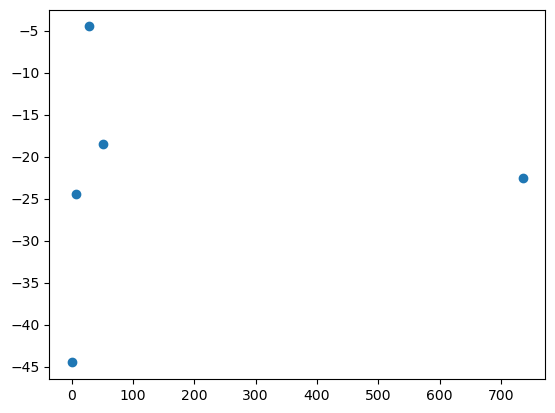

In [40]:
multi_dict = dict(filter(filterer, normalized_dict.items()))

graph_col(normalized_dict, 1637.0, "SYSBP_R")


In [29]:
print(multi_dict.keys())

dict_keys([25.0, 27.0, 28.0, 54.0, 71.0, 95.0, 96.0, 100.0, 120.0, 133.0, 140.0, 148.0, 236.0, 289.0, 299.0, 326.0, 361.0, 394.0, 403.0, 455.0, 470.0, 546.0, 629.0, 682.0, 729.0, 751.0, 800.0, 804.0, 823.0, 836.0, 925.0, 943.0, 949.0, 961.0, 976.0, 977.0, 1018.0, 1031.0, 1050.0, 1058.0, 1059.0, 1104.0, 1162.0, 1193.0, 1204.0, 1247.0, 1260.0, 1271.0, 1286.0, 1287.0, 1297.0, 1299.0, 1329.0, 1368.0, 1386.0, 1388.0, 1389.0, 1416.0, 1493.0, 1534.0, 1555.0, 1597.0, 1605.0, 1623.0, 1637.0, 1700.0, 1704.0, 1706.0, 1707.0, 1716.0, 1753.0, 1754.0, 1757.0, 1793.0, 1804.0, 1818.0, 1870.0, 1928.0, 1938.0, 1982.0, 1984.0, 1996.0, 2011.0, 2054.0, 2124.0, 2156.0, 2196.0, 2199.0, 2270.0, 2285.0, 2301.0, 2313.0, 2330.0, 2334.0, 2389.0, 2410.0, 2420.0, 2434.0, 2450.0, 2483.0, 2524.0, 2525.0, 2536.0, 2561.0, 2614.0, 2617.0, 2659.0, 2719.0, 2871.0, 2876.0, 2911.0, 2920.0, 2926.0, 2936.0, 2964.0, 2971.0, 2995.0, 3034.0, 3062.0, 3064.0, 3130.0, 3185.0, 3186.0, 3189.0, 3194.0, 3374.0, 3430.0, 3448.0, 3459.0, 

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])


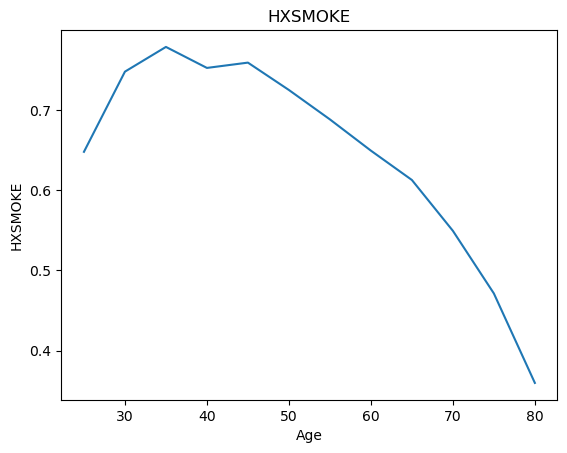

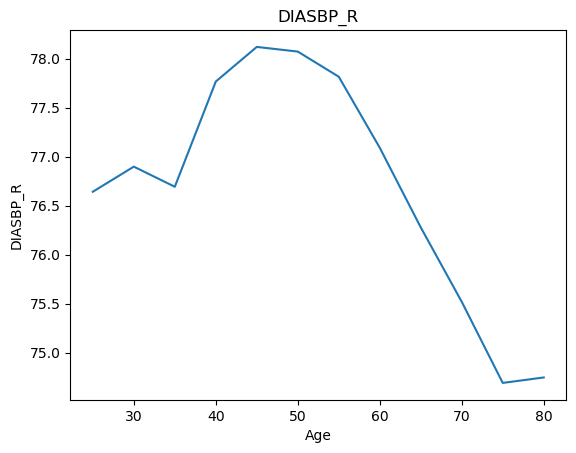

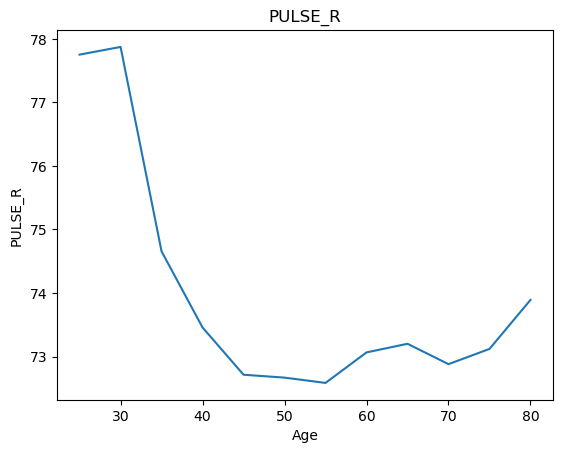

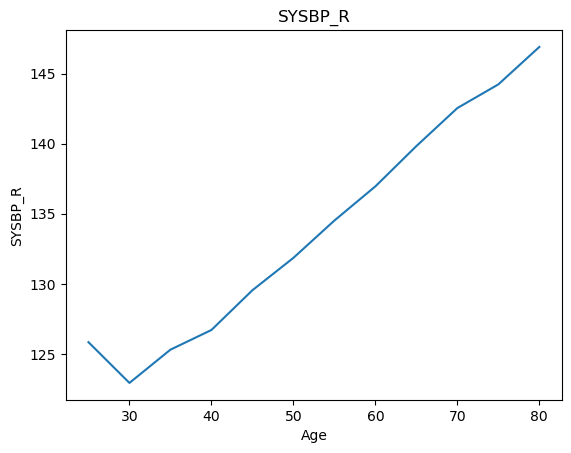

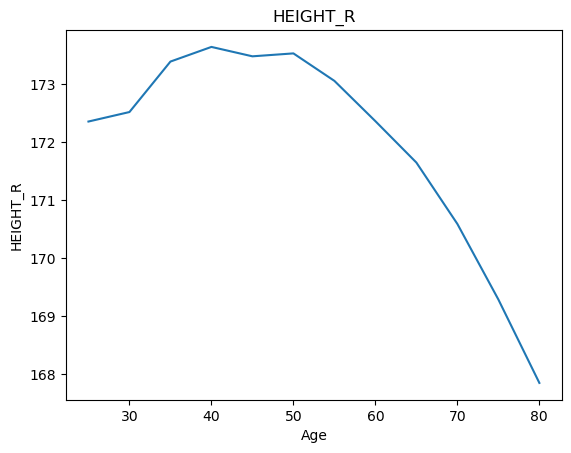

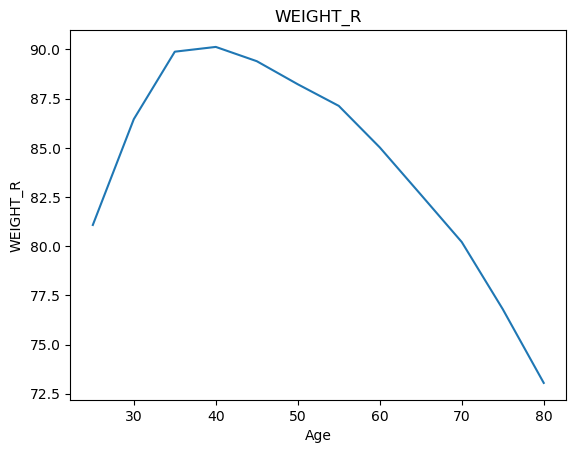

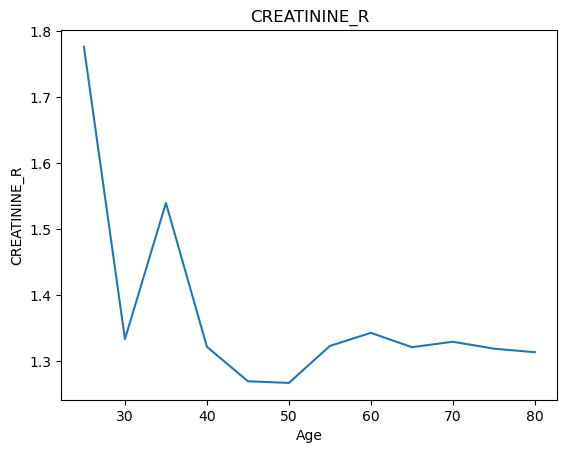

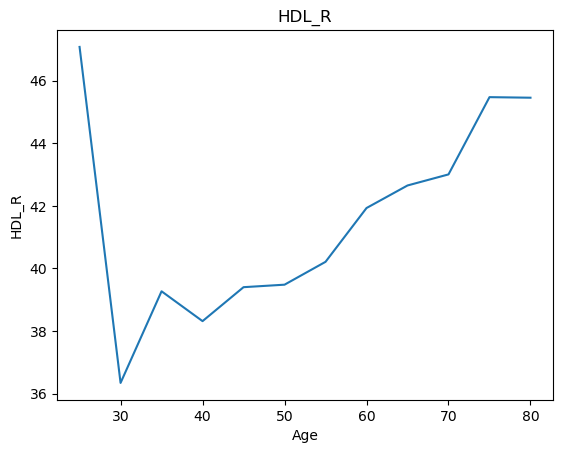

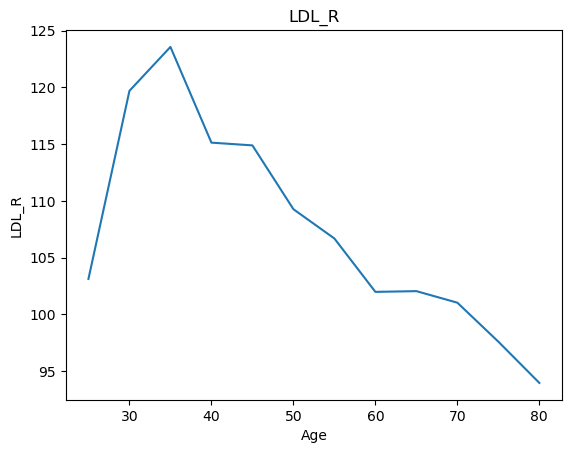

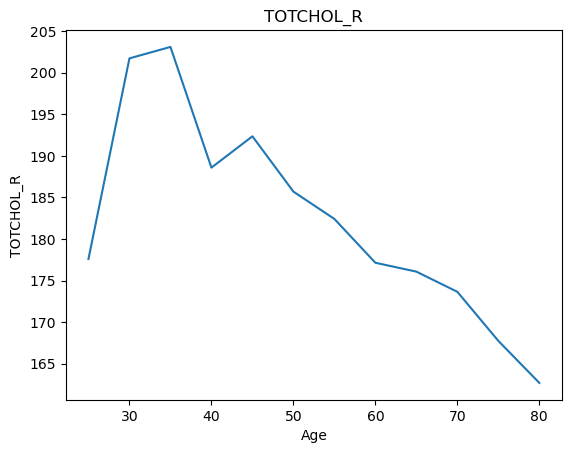

In [5]:

print(trends["HDL_R"].keys())
for k in trends.keys():
    fig = plt.figure(k)
    plt.plot(list(map(lambda x: 15 + 5 * x, list(trends[k].keys()))), [k for i, k in trends[k].items()])
    plt.title(k)
    plt.xlabel("Age")
    plt.ylabel(k)
    plt.show()
# plt.plot(list(trends["LDL_R"].keys()), [k for i, k in trends["LDL_R"].items()])

In [13]:


subj_dict = create_subj_dict(df)
new_dict = drop_bad_rows(subj_dict, 5)
print(len(new_dict))

# print(f'Missing Value Entry: {subj_dict[2][0]["HDL_R"]}')
# # print(find_threshold_num_visits(subj_dict, 0.01))
# # print(find_threshold_num_visits(subj_dict, 100, percentage=False))
# print(avg_interval(subj_dict))
# print(avg_interval(subj_dict, per_instance=False))
# def custom_filter_func(pair):
#     key, value = pair
#     if len(value) >= 9 and ((value[-1]["RDAYSFROMINDEX"] - value[0]["RDAYSFROMINDEX"]) > 750):
#         return True
#     else:
#         return False
# # print(avg_interval(subj_dict, custom_filterer=custom_filter_func))

# def filterer(pair):
#     key, value = pair
#     if len(value) >= 17:
#         return True
#     return False

# # full_dict = remove_missing(subj_dict, "HDL_R")

# # multi_dict = dict(filter(filterer, full_dict.items()))
# # print(list(multi_dict.keys()))

# # graph_col(subj_dict, 91208.0, "YRCATH_G")

# split_subj = split_dict(subj_dict, 1000)
# split_subj = flatten_split_dict(split_subj)

# full_dict = remove_missing(split_subj, "TOTCHOL_R")
 
# multi_dict = dict(filter(custom_filter_func, full_dict.items()))
# print(f'Length of final dataset: {len(list(multi_dict.keys()))}')
# print(list(multi_dict.keys()))

# graph_col(split_subj, 90195.1, "HDL_R")
# graph_col_with_fit(split_subj, 82315.1, "HDL_R")

# # plt.plot(list(range(int(split_subj[41343.2][0]["RDAYSFROMINDEX"]), int(split_subj[41343.2][0]["RDAYSFROMINDEX"]) + 1100, 100)), polyfit_subj(split_subj[41343.2], ["DIASBP_R"])["DIASBP_R"])

# print(find_threshold_num_visits(dict(filter(custom_filter_func, split_subj.items())), 0.01))
# print(find_threshold_num_visits(dict(filter(custom_filter_func, split_subj.items())), 100, percentage=False))
# print(avg_interval(dict(filter(custom_filter_func, split_subj.items())), min_instances=9))
# print(avg_interval(dict(filter(custom_filter_func, split_subj.items())), min_instances=9, per_instance=False))

# print(find_threshold_num_visits(multi_dict, 0.01))
# print(find_threshold_num_visits(multi_dict, 100, percentage=False))
# print(avg_interval(multi_dict, min_instances=9))
# print(avg_interval(multi_dict, min_instances=9, per_instance=False))

1874


In [3]:
subjects = dict()
for index, row in df.iterrows():
    if row["RSUBJID"] not in subjects.keys():
        subjects[row["RSUBJID"]] = list()

    subjects[row["RSUBJID"]].append(row.drop(columns="RSUBJID"))

num_vist_count = dict()
for k in subjects.keys():
    instances = len(subjects[k])
    if instances not in num_vist_count.keys():
        num_vist_count[instances] = 0

    num_vist_count[instances] += 1

for length, num in num_vist_count.items():
    print(f' {length}: {num}')

 1: 22076
 24: 6
 14: 42
 5: 1232
 4: 1970
 2: 7771
 3: 3713
 8: 315
 9: 221
 6: 740
 13: 47
 31: 3
 11: 106
 19: 13
 17: 25
 10: 141
 7: 463
 16: 31
 12: 77
 23: 5
 18: 20
 20: 7
 15: 31
 25: 1
 26: 3
 27: 3
 22: 12
 32: 1
 29: 2
 28: 4
 21: 8
 36: 2
 40: 3
 30: 2
 46: 1
 33: 1
